<a href="https://colab.research.google.com/github/leticiablom/skin-lesion-segmentation-with-enet/blob/main/Segmenta%C3%A7%C3%A3o_de_Les%C3%B5es_de_Pele_com_o_Enet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [2]:
!pip install albumentations==1.4.4
!pip install scikit-image
!pip install kaggle
!pip install -q torch torchvision albumentations segmentation_models_pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.4/150.4 kB 12.1 MB/s eta 0:00:00
  Attempting uninstall: albumentations
    Found existing installation: albumentations 2.0.8
    Uninstalling albumentations-2.0.8:
      Successfully uninstalled albumentations-2.0.8
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 12.2 MB/s eta 0:00:00


In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"letciablom","key":"405b09466519b7d35199dc1808f19e30"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d surajghuwalewala/ham1000-segmentation-and-classification
!unzip ham1000-segmentation-and-classification.zip -d data


A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: data/masks/ISIC_0029321_segmentation.png  
  inflating: data/masks/ISIC_0029322_segmentation.png  
  inflating: data/masks/ISIC_0029323_segmentation.png  
  inflating: data/masks/ISIC_0029324_segmentation.png  
  inflating: data/masks/ISIC_0029325_segmentation.png  
  inflating: data/masks/ISIC_0029326_segmentation.png  
  inflating: data/masks/ISIC_0029327_segmentation.png  
  inflating: data/masks/ISIC_0029328_segmentation.png  
  inflating: data/masks/ISIC_0029329_segmentation.png  
  inflating: data/masks/ISIC_0029330_segmentation.png  
  inflating: data/masks/ISIC_0029331_segmentation.png  
  inflating: data/masks/ISIC_0029332_segmentation.png  
  inflating: data/masks/ISIC_0029333_segmentation.png  
  inflating: data/masks/ISIC_0029334_segmentation.png  
  inflating: data/masks/ISIC_0029335_segmentation.png  
  inflating: data/masks/ISIC_0029336_segmentation.png  
  inflating: data/masks/ISIC_0029337_segmenta

#Diretórios

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

IMAGE_DIR = "data/images"
MASK_DIR  = "data/masks"

print("Imagens:", len(os.listdir(IMAGE_DIR)))
print("Máscaras:", len(os.listdir(MASK_DIR)))

Imagens: 10017
Máscaras: 10015


#Dataset

In [6]:
class HAM10000SegDataset(Dataset):
    def __init__(self, image_dir, mask_dir, file_list, transforms=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.file_list = file_list
        self.transforms = transforms

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_name = self.file_list[idx]

        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name.replace(".jpg", "_segmentation.png"))

        img = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"))
        mask = (mask > 127).astype("uint8")

        if self.transforms:
            aug = self.transforms(image=img, mask=mask)
            img, mask = aug["image"], aug["mask"]
        else:
            aug = A.Compose([A.Resize(256,256), A.Normalize(), ToTensorV2()])(image=img, mask=mask)
            img, mask = aug["image"], aug["mask"]

        return img, mask.unsqueeze(0).float()


#Split entre treino e validação

In [7]:
from sklearn.model_selection import train_test_split

valid_ext = [".jpg", ".jpeg", ".png"]
all_imgs = sorted([f for f in os.listdir(IMAGE_DIR) if os.path.splitext(f)[1].lower() in valid_ext])

train_imgs, val_imgs = train_test_split(all_imgs, test_size=0.2, random_state=42)

len(train_imgs), len(val_imgs)


(8012, 2003)

#Transforms

In [8]:
train_tf = A.Compose([
    A.Resize(256,256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Normalize(),
    ToTensorV2(),
])

val_tf = A.Compose([
    A.Resize(256,256),
    A.Normalize(),
    ToTensorV2(),
])


#Datasets e DataLoaders

In [9]:
train_ds = HAM10000SegDataset(IMAGE_DIR, MASK_DIR, train_imgs, transforms=train_tf)
val_ds   = HAM10000SegDataset(IMAGE_DIR, MASK_DIR, val_imgs, transforms=val_tf)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=2)


#Modelo Enet

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F



# ------------------------------
# Blocks definition
# ------------------------------

class InitialBlock(nn.Module):
    def __init__(self, in_channels=3, out_channels=16):
        super().__init__()
        self.main_branch = nn.Conv2d(in_channels, out_channels-3, 3, stride=2, padding=1, bias=False)
        self.ext_branch  = nn.MaxPool2d(2, stride=2)
        self.bn = nn.BatchNorm2d(out_channels)
        self.prelu = nn.PReLU()

    def forward(self, x):
        main = self.main_branch(x)
        ext  = self.ext_branch(x)
        out = torch.cat((main, ext), dim=1)
        out = self.bn(out)
        return self.prelu(out)



class DownsampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.main = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.PReLU(),
        )

        self.ext = nn.MaxPool2d(2, stride=2, return_indices=True)

    def forward(self, x):
        main = self.main(x)
        ext, indices = self.ext(x)

        if ext.shape[1] != main.shape[1]:
            diff = main.shape[1] - ext.shape[1]
            ext = F.pad(ext, (0,0,0,0,0,diff))

        return main + ext, indices



class RegularBottleneck(nn.Module):
    def __init__(self, channels, dilation=1, asymmetric=False, p=0.1):
        super().__init__()
        internal = channels // 4

        self.reduce = nn.Sequential(
            nn.Conv2d(channels, internal, 1, bias=False),
            nn.BatchNorm2d(internal),
            nn.PReLU()
        )

        if asymmetric:
            self.conv = nn.Sequential(
                nn.Conv2d(internal, internal, (1,5), padding=(0,2), bias=False),
                nn.Conv2d(internal, internal, (5,1), padding=(2,0), bias=False),
            )
        else:
            self.conv = nn.Conv2d(internal, internal, 3, padding=dilation, dilation=dilation, bias=False)

        self.bn = nn.BatchNorm2d(internal)
        self.prelu = nn.PReLU()

        self.expand = nn.Sequential(
            nn.Conv2d(internal, channels, 1, bias=False),
            nn.BatchNorm2d(channels),
            nn.Dropout2d(p)
        )

    def forward(self, x):
        identity = x

        out = self.reduce(x)
        out = self.prelu(self.bn(self.conv(out)))
        out = self.expand(out)

        return self.prelu(out + identity)



class UpsampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        internal = in_channels // 4

        self.reduce = nn.Sequential(
            nn.Conv2d(in_channels, internal, 1, bias=False),
            nn.BatchNorm2d(internal),
            nn.PReLU()
        )

        self.deconv = nn.ConvTranspose2d(internal, internal, 3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn = nn.BatchNorm2d(internal)
        self.prelu = nn.PReLU()

        self.expand = nn.Sequential(
            nn.Conv2d(internal, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

        self.ext_conv = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, 2, stride=2, bias=False),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        identity = self.ext_conv(x)

        out = self.reduce(x)
        out = self.prelu(self.bn(self.deconv(out)))
        out = self.expand(out)

        return self.prelu(out + identity)



# ------------------------------
# ENet final
# ------------------------------

class ENet(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()

        self.initial = InitialBlock()

        self.down1 = DownsampleBlock(16, 64)
        self.stage1 = nn.Sequential(
            RegularBottleneck(64),
            RegularBottleneck(64),
            RegularBottleneck(64),
            RegularBottleneck(64),
            RegularBottleneck(64),
        )

        self.down2 = DownsampleBlock(64, 128)
        self.stage2 = nn.Sequential(
            RegularBottleneck(128),
            RegularBottleneck(128, dilation=2),
            RegularBottleneck(128, asymmetric=True),
            RegularBottleneck(128, dilation=4),
            RegularBottleneck(128),
            RegularBottleneck(128, dilation=8),
            RegularBottleneck(128, asymmetric=True),
            RegularBottleneck(128, dilation=16),
        )

        self.stage3 = nn.Sequential(
            RegularBottleneck(128),
            RegularBottleneck(128),
            RegularBottleneck(128),
            RegularBottleneck(128),
            RegularBottleneck(128),
        )

        self.up4 = UpsampleBlock(128, 64)
        self.up5 = UpsampleBlock(64, 16)

        self.final = nn.ConvTranspose2d(16, num_classes, 2, stride=2)

    def forward(self, x):
        x = self.initial(x)

        x, _ = self.down1(x)
        x = self.stage1(x)

        x, _ = self.down2(x)
        x = self.stage2(x)

        x = self.stage3(x)

        x = self.up4(x)
        x = self.up5(x)

        x = self.final(x)
        return x

model = ENet(num_classes=1).to(device)


#Funções de loss e métricas

In [11]:
def dice_loss(pred, target, smooth=1):
    pred = torch.sigmoid(pred)
    pred = pred.view(-1)
    target = target.view(-1)
    inter = (pred * target).sum()
    return 1 - (2*inter + smooth) / (pred.sum() + target.sum() + smooth)

def iou_score(pred, target, thr=0.5):
    pred = torch.sigmoid(pred) > thr
    pred = pred.float()
    inter = (pred * target).sum()
    union = (pred + target - pred * target).sum()
    return (inter + 1e-6) / (union + 1e-6)


# Loop de treinamento

In [12]:
from tqdm import tqdm

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 20
best_iou = 0

for epoch in range(epochs):

    # TRAIN
    model.train()
    train_loss = 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    for imgs, masks in loop:
        imgs, masks = imgs.to(device), masks.to(device)

        preds = model(imgs)

        bce  = F.binary_cross_entropy_with_logits(preds, masks)
        d    = dice_loss(preds, masks)
        loss = bce + d

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * imgs.size(0)
        loop.set_postfix(loss=loss.item())

    train_loss /= len(train_ds)

    # VAL
    model.eval()
    val_loss = 0
    val_iou  = []

    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)

            preds = model(imgs)
            bce = F.binary_cross_entropy_with_logits(preds, masks)
            d   = dice_loss(preds, masks)
            loss = bce + d

            val_loss += loss.item() * imgs.size(0)
            val_iou.append(iou_score(preds, masks).item())

    val_loss /= len(val_ds)
    mean_iou = np.mean(val_iou)

    print(f"Epoch {epoch+1}: Train={train_loss:.4f} | Val={val_loss:.4f} | IoU={mean_iou:.4f}")

    # Save best
    if mean_iou > best_iou:
        best_iou = mean_iou
        torch.save(model.state_dict(), "enet_best.pth")
        print("Novo melhor modelo salvo.")


Epoch 1/20: 100%|██████████| 1002/1002 [01:31<00:00, 10.89it/s, loss=0.22]


Epoch 1: Train=0.4019 | Val=0.2540 | IoU=0.8318
Novo melhor modelo salvo.


Epoch 2/20: 100%|██████████| 1002/1002 [01:30<00:00, 11.12it/s, loss=0.207]


Epoch 2: Train=0.2610 | Val=0.2164 | IoU=0.8522
Novo melhor modelo salvo.


Epoch 3/20: 100%|██████████| 1002/1002 [01:31<00:00, 10.96it/s, loss=0.56]


Epoch 3: Train=0.2367 | Val=0.2150 | IoU=0.8546
Novo melhor modelo salvo.


Epoch 4/20: 100%|██████████| 1002/1002 [01:30<00:00, 11.13it/s, loss=0.147]


Epoch 4: Train=0.2219 | Val=0.1993 | IoU=0.8639
Novo melhor modelo salvo.


Epoch 5/20: 100%|██████████| 1002/1002 [01:30<00:00, 11.11it/s, loss=0.103]


Epoch 5: Train=0.2138 | Val=0.2087 | IoU=0.8598


Epoch 6/20: 100%|██████████| 1002/1002 [01:30<00:00, 11.08it/s, loss=0.155]


Epoch 6: Train=0.2060 | Val=0.1922 | IoU=0.8703
Novo melhor modelo salvo.


Epoch 7/20: 100%|██████████| 1002/1002 [01:30<00:00, 11.12it/s, loss=0.0887]


Epoch 7: Train=0.2024 | Val=0.1908 | IoU=0.8705
Novo melhor modelo salvo.


Epoch 8/20: 100%|██████████| 1002/1002 [01:29<00:00, 11.14it/s, loss=0.13]


Epoch 8: Train=0.1980 | Val=0.1901 | IoU=0.8690


Epoch 9/20: 100%|██████████| 1002/1002 [01:28<00:00, 11.26it/s, loss=0.107]


Epoch 9: Train=0.1955 | Val=0.1866 | IoU=0.8721
Novo melhor modelo salvo.


Epoch 10/20: 100%|██████████| 1002/1002 [01:31<00:00, 10.99it/s, loss=0.0935]


Epoch 10: Train=0.1909 | Val=0.1791 | IoU=0.8779
Novo melhor modelo salvo.


Epoch 11/20: 100%|██████████| 1002/1002 [01:30<00:00, 11.07it/s, loss=0.83]


Epoch 11: Train=0.1891 | Val=0.1784 | IoU=0.8781
Novo melhor modelo salvo.


Epoch 12/20: 100%|██████████| 1002/1002 [01:30<00:00, 11.11it/s, loss=0.277]


Epoch 12: Train=0.1853 | Val=0.1842 | IoU=0.8727


Epoch 13/20: 100%|██████████| 1002/1002 [01:28<00:00, 11.27it/s, loss=0.192]


Epoch 13: Train=0.1813 | Val=0.1777 | IoU=0.8800
Novo melhor modelo salvo.


Epoch 14/20: 100%|██████████| 1002/1002 [01:28<00:00, 11.26it/s, loss=0.0729]


Epoch 14: Train=0.1812 | Val=0.1781 | IoU=0.8785


Epoch 15/20: 100%|██████████| 1002/1002 [01:28<00:00, 11.30it/s, loss=0.0629]


Epoch 15: Train=0.1773 | Val=0.1871 | IoU=0.8734


Epoch 16/20: 100%|██████████| 1002/1002 [01:30<00:00, 11.06it/s, loss=0.0862]


Epoch 16: Train=0.1780 | Val=0.1868 | IoU=0.8734


Epoch 17/20: 100%|██████████| 1002/1002 [01:31<00:00, 10.99it/s, loss=0.235]


Epoch 17: Train=0.1741 | Val=0.1762 | IoU=0.8792


Epoch 18/20: 100%|██████████| 1002/1002 [01:31<00:00, 10.96it/s, loss=0.283]


Epoch 18: Train=0.1724 | Val=0.1815 | IoU=0.8772


Epoch 19/20: 100%|██████████| 1002/1002 [01:31<00:00, 10.95it/s, loss=0.436]


Epoch 19: Train=0.1690 | Val=0.1777 | IoU=0.8779


Epoch 20/20: 100%|██████████| 1002/1002 [01:31<00:00, 10.93it/s, loss=0.209]


Epoch 20: Train=0.1668 | Val=0.1711 | IoU=0.8824
Novo melhor modelo salvo.


# Visualização

Total de imagens disponíveis: 2003


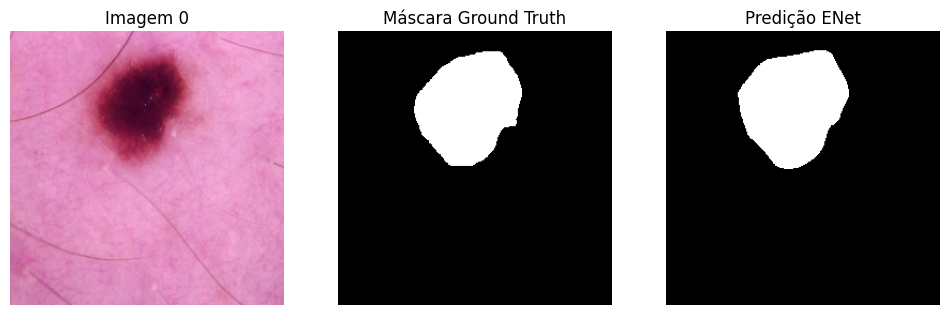

In [14]:
from ipywidgets import widgets, HBox, VBox
import matplotlib.pyplot as plt
import numpy as np
import torch

# -------------------------------------------------------------------
# Pega TODOS os batches da validação e guarda as imagens e máscaras
# -------------------------------------------------------------------
model.eval()

all_imgs_list = []
all_masks_list = []
all_preds_list = []

with torch.no_grad():
    for imgs, masks in val_loader:
        preds = torch.sigmoid(model(imgs.to(device))).cpu().numpy()
        all_imgs_list.append(imgs.cpu().numpy())
        all_masks_list.append(masks.cpu().numpy())
        all_preds_list.append(preds)

# Converte tudo para arrays unificados
all_imgs = np.concatenate(all_imgs_list, axis=0)
all_masks = np.concatenate(all_masks_list, axis=0)
all_preds = np.concatenate(all_preds_list, axis=0)

print(f"Total de imagens disponíveis: {len(all_imgs)}")


# -------------------------------------------------------------------
# Função para exibir imagem, máscara e predição
# -------------------------------------------------------------------
def plot_image(idx):
    img = all_imgs[idx]
    mask = all_masks[idx, 0]
    pred = all_preds[idx, 0] > 0.5

    img = np.transpose(img, (1, 2, 0))
    img = (img - img.min()) / (img.max() - img.min())

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title(f"Imagem {idx}")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap="gray")
    plt.title("Máscara Ground Truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred, cmap="gray")
    plt.title("Predição ENet")
    plt.axis("off")

    plt.show()


# -------------------------------------------------------------------
# Widgets: botões e slider
# -------------------------------------------------------------------
idx_slider = widgets.IntSlider(
    value=0, min=0, max=len(all_imgs)-1, step=1, description="Índice:"
)

btn_prev = widgets.Button(description="Anterior")
btn_next = widgets.Button(description="Próxima")


def on_prev_clicked(b):
    if idx_slider.value > 0:
        idx_slider.value -= 1


def on_next_clicked(b):
    if idx_slider.value < len(all_imgs)-1:
        idx_slider.value += 1


btn_prev.on_click(on_prev_clicked)
btn_next.on_click(on_next_clicked)


def update_view(change):
    plot_image(change["new"])


idx_slider.observe(update_view, names="value")

# Exibe o primeiro automaticamente
plot_image(0)

# Layout final
widgets.VBox([
    idx_slider,
    HBox([btn_prev, btn_next])
])


# Avaliação

Calcular IoU e Dice por imagem

In [15]:
import numpy as np

def compute_iou(pred, gt, eps=1e-6):
    inter = (pred & gt).sum()
    union = (pred | gt).sum()
    return (inter + eps) / (union + eps)

def compute_dice(pred, gt, eps=1e-6):
    inter = (pred & gt).sum()
    return (2*inter + eps) / (pred.sum() + gt.sum() + eps)


all_iou = []
all_dice = []

model.eval()
with torch.no_grad():
    for imgs, masks in val_loader:
        preds = torch.sigmoid(model(imgs.to(device))).cpu().numpy()

        masks_np = masks.numpy()

        for i in range(len(preds)):
            pred = (preds[i,0] > 0.5).astype(np.uint8)
            gt   = masks_np[i,0].astype(np.uint8)

            all_iou.append(compute_iou(pred, gt))
            all_dice.append(compute_dice(pred, gt))


# IoU — Intersection over Union

Representa o quanto a área prevista intersecta com a área verdadeira.

IoU = Parte correta / (Parte correta + erros)

# Dice Coefficient

Parecido com IoU, mas é menos severo com pequenos erros.

Dice = 2 * área correta / (área prevista + área verdadeira)

In [ ]:
print("IoU médio:", np.mean(all_iou))
print("Dice médio:", np.mean(all_dice))
print("IoU mínimo:", np.min(all_iou))
print("IoU máximo:", np.max(all_iou))

# Gráficos

Histograma do IoU

Esse gráfico mostra como o seu modelo se comporta em todas as imagens.


---



O eixo X (horizontal)

Representa os valores de IoU que o modelo atingiu:

*   0.0 → ruim (quase nada da lesão foi segmentado corretamente)
*   0.3 → fraco
*   0.5 → aceitável
*   0.7+ → bom
*   0.85+ → excelente


---


O eixo Y (vertical)

Mostra quantas imagens tiveram aquele nível de IoU.

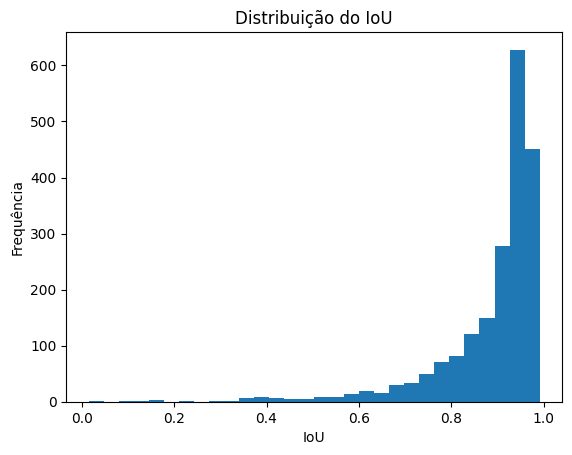

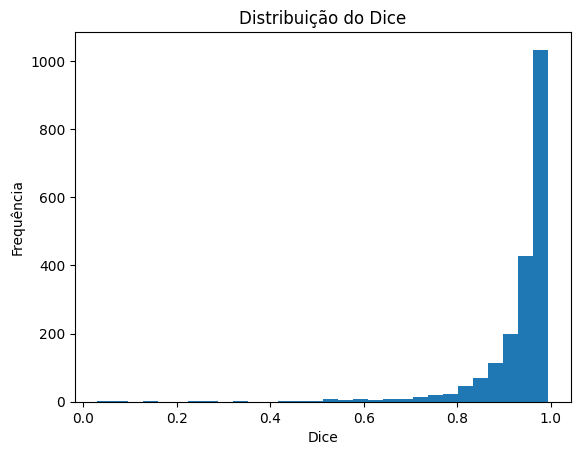

In [16]:
import matplotlib.pyplot as plt

plt.hist(all_iou, bins=30)
plt.title("Distribuição do IoU")
plt.xlabel("IoU")
plt.ylabel("Frequência")
plt.show()

plt.hist(all_dice, bins=30)
plt.title("Distribuição do Dice")
plt.xlabel("Dice")
plt.ylabel("Frequência")
plt.show()